# Fortune 500 Debt Risk Classification

### Business Objective
The goal of this project is to build a supervised classification model that assigns Fortune 500 companies to debt‑risk bands using financial fundamentals. The analysis intentionally excludes direct leverage components (e.g., Total Liabilities, Total Assets) from the predictors to test whether indirect indicators can meaningfully predict leverage risk.

### Initial hypothesis: 
Lower profitability would be associated with higher leverage risk. 
### Finding:
The modelling process revealed financing burden (interest expense) as a stronger structural driver.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import f_oneway

## 1. Data Ingestion

In [2]:
fundamentals = pd.read_csv('fundamentals.csv', index_col=0)
securities = pd.read_csv('securities.csv') 

## 2. Data Cleaning and Preparation
Financial statements were converted to datetime format. Debt Ratio was engineered as Total Liabilities divided by Total Assets. Datasets were merged using ticker symbol and filtered to a consistent five-year window (2012–2016).

### 2.1 Data Handling and Engineering

In [5]:
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'])
fundamentals['Year'] = fundamentals['Period Ending'].dt.year
fundamentals['Debt Ratio'] = fundamentals['Total Liabilities'] / fundamentals['Total Assets']

### 2.2 Merge datasets

In [6]:
securities = securities.rename(
    columns={'Ticker symbol': 'Ticker Symbol'}
)

wholedf = fundamentals.merge(
    securities[['Ticker Symbol', 'Security','GICS Sector', 'GICS Sub Industry', ]],
    on='Ticker Symbol',
    how='left'
)

wholedf5 = wholedf[(wholedf['Year'] >= 2012) & (wholedf['Year'] <= 2016)].copy()

### 2.3 Missing Data Considerations
* Liquidity ratios (Quick, Current, Cash) are frequently unreported → removed.
* Shareholder metrics (EPS, ESO) also removed due to sparse reporting.
* “For Year” dropped as redundant with Period Ending.
* Negative values were inspected and deemed valid for the variables involved.

In [7]:
wholedf5.isna().sum().sort_values(ascending=False).head(10)

Cash Ratio                      299
Current Ratio                   299
Quick Ratio                     299
Estimated Shares Outstanding    214
Earnings Per Share              214
For Year                        168
Accounts Receivable               0
Accounts Payable                  0
Period Ending                     0
After Tax ROE                     0
dtype: int64

## 3. Exploratory Data Analysis 

### 3.1 Dataset Overview
* 1,776 rows (company‑year observations)
* 83 financial variables
* Mix of numeric and categorical fields

### 3.2 Explore Target Variable - Debt Ratio (DR)
Debt Ratio shows moderate right skew with several high-leverage outliers.  

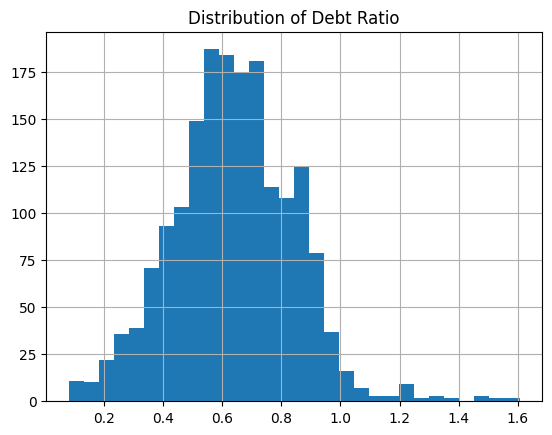

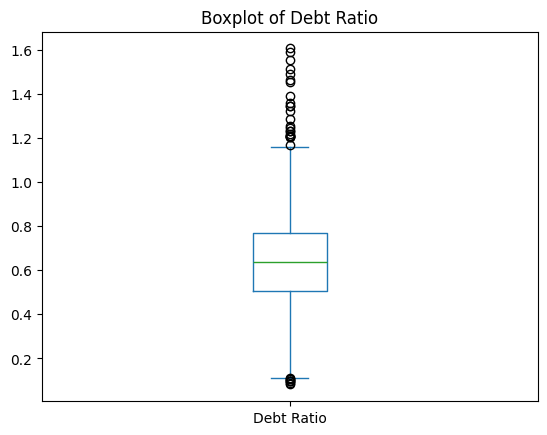

In [8]:
wholedf5['Debt Ratio'].describe()
wholedf5['Debt Ratio'].hist(bins=30)
plt.title('Distribution of Debt Ratio')
plt.show()

wholedf5['Debt Ratio'].plot(kind='box')
plt.title('Boxplot of Debt Ratio')
plt.show()

### 3.3 Explore Assets and Liabilities contributing to Debt Ratio
Both variables exhibit extreme right skew. Log transformation improves interpretability.

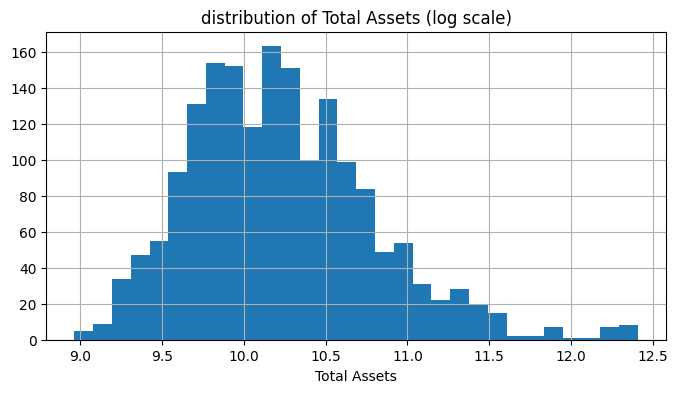

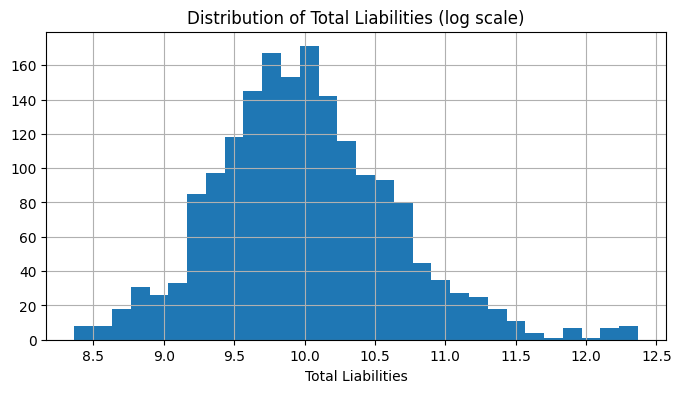

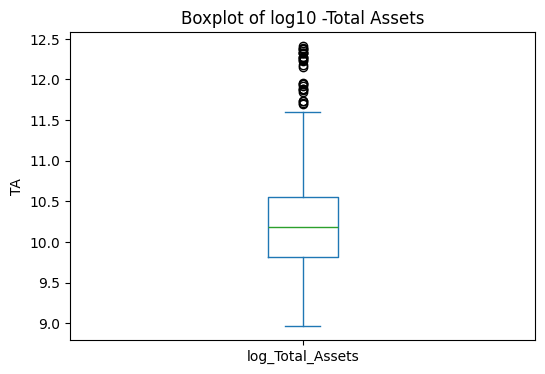

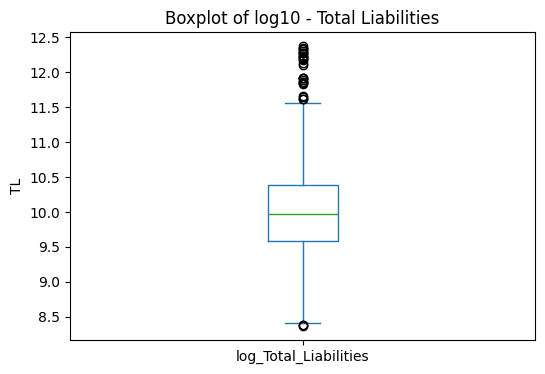

In [12]:
wholedf5['log_Total_Assets'] = np.log10(fundamentals['Total Assets'])
wholedf5['log_Total_Liabilities'] = np.log10(fundamentals['Total Liabilities'])

plt.figure(figsize=(8, 4))
wholedf5['log_Total_Assets'].hist(bins=30)
plt.xlabel('Total Assets')
plt.title('distribution of Total Assets (log scale)')
plt.show()

plt.figure(figsize=(8, 4))
wholedf5['log_Total_Liabilities'].hist(bins=30)
plt.xlabel('Total Liabilities')
plt.title('Distribution of Total Liabilities (log scale)')
plt.show()

plt.figure(figsize=(6, 4))
wholedf5['log_Total_Assets'].plot(kind='box')
plt.title('Boxplot of log10 -Total Assets')
plt.ylabel('TA')
plt.show()

plt.figure(figsize=(6, 4))
wholedf5['log_Total_Liabilities'].plot(kind='box')
plt.title('Boxplot of log10 - Total Liabilities')
plt.ylabel('TL')
plt.show()

### 3.4 GICS Sector Level Analysis
* Debt ratios vary structurally by sector.
* High‑leverage sectors: Utilities, Telecom, Financials, Real Estate.
* Lower‑leverage sectors: IT, Services, Consumer industries.

In [14]:
wholedf5['GICS Sector'] = wholedf['GICS Sector'].astype('category')
wholedf5['GICS Sector'].value_counts()

(wholedf5
    .groupby('GICS Sector')['Debt Ratio']
    .agg(['count', 'mean', 'median', 'min', 'max'])
    .sort_values('mean', ascending=False))

,count,mean,median,min,max
GICS Sector,,,,,
Financials,211,0.822691,0.870117,0.276160,1.110278
Telecommunications Services,20,0.761435,0.730431,0.580617,0.947132
Utilities,96,0.723975,0.714954,0.639917,0.837771
Consumer Staples,128,0.675505,0.639022,0.152555,1.390034
Industrials,248,0.657678,0.631026,0.146011,1.605830
Materials,95,0.646496,0.661561,0.257691,0.928818
Real Estate,108,0.625898,0.622296,0.387351,0.919875
Consumer Discretionary,316,0.606920,0.599855,0.165239,1.590266
Health Care,193,0.594160,0.579264,0.109313,1.344078


### 3.5 Hypothesis Check: Profit Margin vs Debt Ratio
Profit margin alone shows no strong linear relationship with leverage.

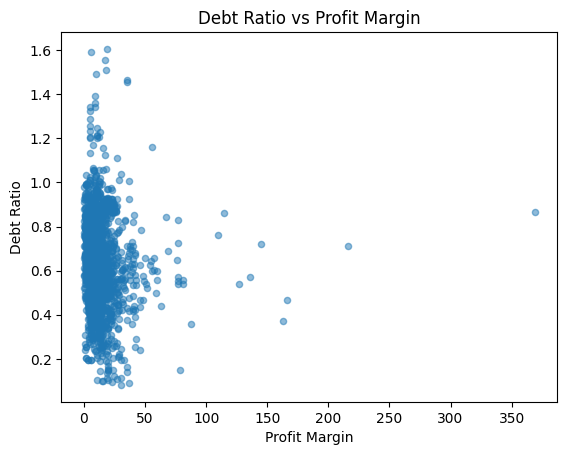

In [15]:
wholedf5[['Profit Margin','Debt Ratio']].describe()

wholedf5.plot.scatter(x='Profit Margin', y='Debt Ratio', alpha=0.5)
plt.title('Debt Ratio vs Profit Margin')
plt.show()

## 4. Creating Debt Risks Categories
Debt Ratio quartiles were used to create four balanced risk bands: Very Low, Low, High, Very High

In [16]:
q1, q2, q3 = wholedf5['Debt Ratio'].quantile([0.25, 0.5, 0.75])

def classdr4(x):
    if x < q1: return 'Very Low'
    elif x < q2: return 'Low'
    elif x < q3: return 'High'
    else: return 'Very High'

wholedf5['Debt Risk'] = wholedf5['Debt Ratio'].apply(classdr4)
wholedf5['Debt Risk'].value_counts()

Debt Risk
Very High    444
High         444
Very Low     444
Low          444
Name: count, dtype: int64

## 5. Correlation Analysis
To understand relationships among the numeric predictors, a correlation matrix was computed using only numerical features.
Categorical variables such as GICS Sector were excluded because correlation requires numeric inputs.

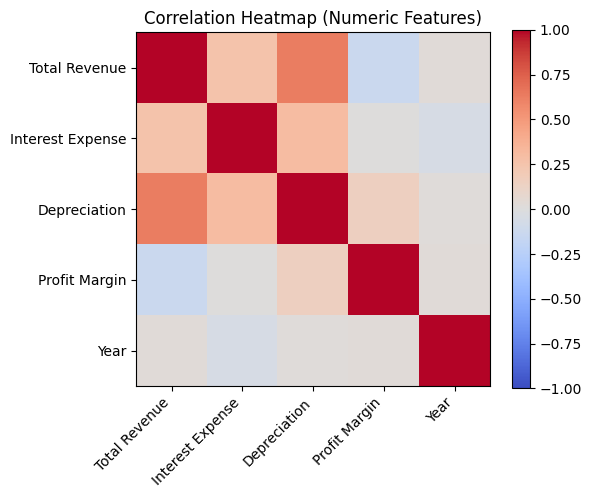

In [18]:
numeric_features = wholedf5[
    ['Total Revenue', 'Interest Expense', 'Depreciation',
     'Profit Margin', 'Year']
]

corrmatrix = numeric_features.corr()

plt.figure(figsize=(6, 5))
im = plt.imshow(corrmatrix, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(im)

tick_positions = np.arange(len(corrmatrix.columns))
plt.xticks(tick_positions, corrmatrix.columns, rotation=45, ha='right')
plt.yticks(tick_positions, corrmatrix.columns)

plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()


#### Interpretation
Debt Ratio (not included here to avoid leakage) is only weakly related to indirect indicators.

Interest Expense shows mild positive association with scale variables (Revenue, Depreciation).

Profit Margin has weak negative relationships with scale‑based variables, consistent with expectations.

### 6. Comparison Over Time Analysis
Overall leverage levels remain broadly stable, but risk concentration increases temporarily in the middle years.
This reinforces that debt risk is sector‑dependent and structurally persistent, supporting the use of cross‑sectional financial predictors in the classification model.

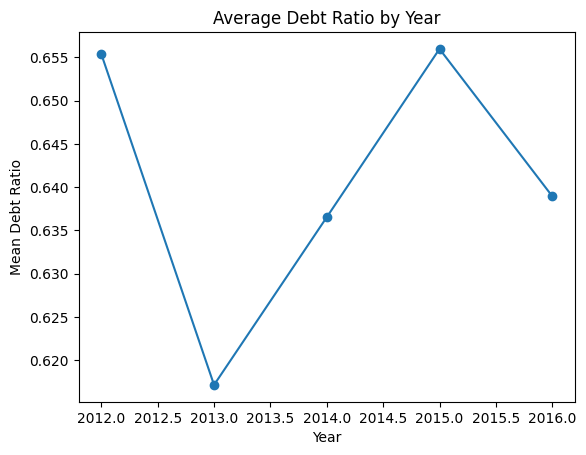

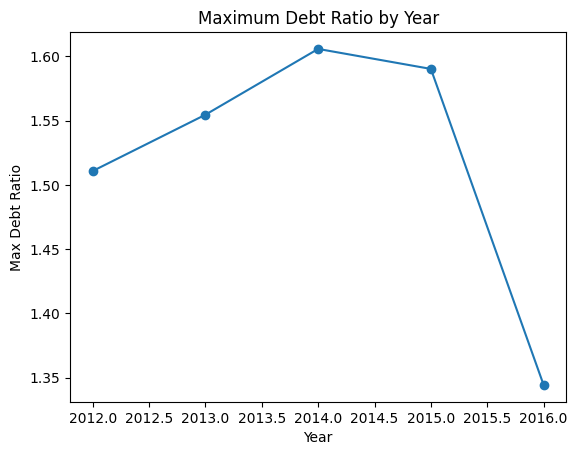

In [22]:
# debt ratio stats for each year
yearstat = (
    wholedf5
    .groupby('Year')['Debt Ratio']
    .agg(['count', 'mean', 'median', 'max'])
)

yearstat['mean'].plot(marker='o')
plt.title('Average Debt Ratio by Year')
plt.ylabel('Mean Debt Ratio')
plt.xlabel('Year')
plt.show()

yearstat['max'].plot(marker='o')
plt.title('Maximum Debt Ratio by Year')
plt.ylabel('Max Debt Ratio')
plt.xlabel('Year')
plt.show()

In [23]:
#Examining the mean for each sector across each year
year_sector_mean = (
    wholedf5
    .groupby(['Year', 'GICS Sector'])['Debt Ratio']
    .mean()
    .unstack()
)

year_sector_mean

GICS Sector,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services,Utilities
Year,,,,,,,,,,,
2012,0.603335,0.701212,0.558676,0.808646,0.614571,0.649532,0.490235,0.612902,0.641656,0.767276,0.722568
2013,0.583682,0.638407,0.555387,0.819908,0.561256,0.629719,0.471130,0.614547,0.619930,0.769085,0.717372
2014,0.604630,0.657785,0.556702,0.827194,0.597775,0.655537,0.500662,0.657918,0.619446,0.768140,0.724098
2015,0.624713,0.698434,0.597979,0.831181,0.620867,0.670730,0.534613,0.675694,0.625008,0.741238,0.726655
2016,0.618269,0.707924,0.571591,0.827569,0.578324,0.691915,0.568634,0.689299,0.625136,NaN,0.753809


### 7. Feature Selection
To avoid structural leakage, Total Assets and Total Liabilities were excluded from modelling.

Selected predictors reflect profitability, operating performance, scale and sector structure:

* Total Revenue
* Interest Expense
* Depreciation
* Profit Margin
* Year
* GICS Sector

In [24]:
target = wholedf5['Debt Risk']
features1 = wholedf5[['Total Revenue', 'Interest Expense', 'Depreciation', 'Profit Margin', 'Year', 'GICS Sector']]

featuresencoded = pd.get_dummies(features1, columns=['GICS Sector'], drop_first=False)

## 8. Modelling

### 8.1 Train/Test Split

In [29]:
#Split data into train and test (70-30) with balanced class distributions
X_train, X_test, y_train, y_test = train_test_split(
    featuresencoded, target, test_size=0.3, random_state=0,stratify=target
)

### 8.2 Classifier Models
Three models were evaluated:
* Random Forest
* Gradient Boosting
* K‑Nearest Neighbours

In [30]:
#Develop the 3 models through pipeline - Random Forest Classifier, Gradient Boosting Classifier and K Nearest Neighbors Classifier
rfclassifier = Pipeline(steps=[('model', RandomForestClassifier(n_estimators=200, n_jobs=1, random_state=0))
                              ]
                       )
gbclassifier = Pipeline(steps=[('model', GradientBoostingClassifier(n_estimators=200, random_state=0))
                              ]
                       )
knnclassifier = Pipeline(steps=[('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=5)
                                                              )
                               ]
                        )

models = {'Random Forest': rfclassifier,
         'Gradient Boosting': gbclassifier,
         'KNN': knnclassifier}


### 8.3 Model Evaluation
Each classifier was trained on the 70/30 train–test split and evaluated using accuracy, macro recall, and macro F1.
The updated results are:
* Random Forest is the strongest performer, achieving ~66% accuracy and balanced performance across classes.
* Gradient Boosting performs moderately (~59%), weaker than expected relative to earlier runs.
* KNN remains the weakest model (~41%), struggling with the multi‑class structure and scale differences despite standardisation.
Overall, the tree‑based models continue to outperform distance‑based methods, with Random Forest providing the most reliable classification of the four debt‑risk bands.

In [31]:
results = []

for name, model in models.items():
    print(f'{name}')
        
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    macro_recall = recall_score(y_test, y_pred, average='macro') 
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
     # Print confusion matrix
    print('Confusion matrix:')
    print(pd.crosstab(y_test, y_pred,
                      rownames=['Actual'], colnames=['Predicted']))
    print()
    
    # Create table with results
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Macro Recall (≈ Bal Acc)': macro_recall,
        'Macro F1': f1_macro
    })

results_df = pd.DataFrame(results)
results_df

Random Forest
Confusion matrix:
Predicted  High  Low  Very High  Very Low
Actual                                   
High         77   24         29         4
Low          17   81          9        26
Very High    22   10         96         5
Very Low      5   27          2        99

Gradient Boosting
Confusion matrix:
Predicted  High  Low  Very High  Very Low
Actual                                   
High         77   22         29         6
Low          24   65         15        29
Very High    18   17         85        13
Very Low     13   30          2        88

KNN
Confusion matrix:
Predicted  High  Low  Very High  Very Low
Actual                                   
High         60   34         26        14
Low          34   45         13        41
Very High    33   24         64        12
Very Low     34   42          5        52



,Model,Accuracy,Macro Recall (≈ Bal Acc),Macro F1
0,Random Forest,0.662289,0.662454,0.662085
1,Gradient Boosting,0.590994,0.591025,0.591013
2,KNN,0.414634,0.414572,0.418585


## 9. Random Forest Hyperparameter Optimisation
GridSearchCV confirmed that the baseline RF configuration was already near‑optimal.

In [32]:
# Gradient Boosting model
rf = RandomForestClassifier(random_state=0)

# hyperparameters trialled
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

grid_search.best_params_, grid_search.best_score_

({'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 np.float64(0.6155965607951112))

## 10. Feature Importance (Random Forest)
The Random Forest model shows that Interest Expense, Total Revenue, and Depreciation are the strongest predictors of debt‑risk bands, reflecting financing burden, firm scale, and asset intensity. Profit Margin also contributes meaningfully, while Year and sector indicators such as Financials, Utilities, and Information Technology add smaller but still useful signals. Overall, the model relies most heavily on operational scale and financing costs to distinguish between the four risk categories.

In [39]:
# Fit Random Forest as the final model
finalmodel = RandomForestClassifier(
    n_estimators=200,
    random_state=0,
    n_jobs=-1
)

finalmodel.fit(X_train, y_train)

# Extract feature importances
importances = finalmodel.feature_importances_
feature_names = X_train.columns

feat_imp_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp_rf.head(18)

,feature,importance
1,Interest Expense,0.226599
0,Total Revenue,0.191396
2,Depreciation,0.185913
3,Profit Margin,0.143775
4,Year,0.064960
8,GICS Sector_Financials,0.057764
15,GICS Sector_Utilities,0.024311
11,GICS Sector_Information Technology,0.016959
10,GICS Sector_Industrials,0.015674
5,GICS Sector_Consumer Discretionary,0.015461


<Axes: xlabel='feature'>

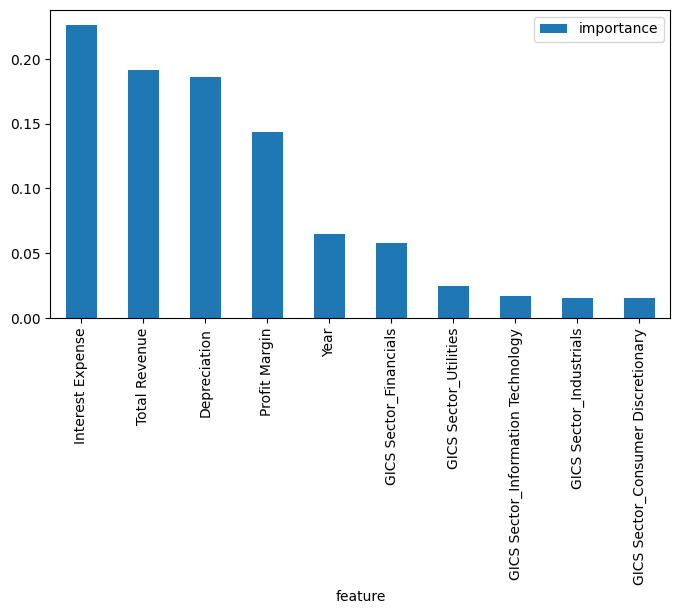

In [40]:
feat_imp_rf.head(10).plot.bar(x='feature',
                                              y='importance', 
                                              figsize=(8, 4)
                                             )

## 11. Supplementary Statistical Analysis
A one-way ANOVA was conducted to evaluate whether Interest Expense means differ across debt risk bands. Interest Expense differs significantly across risk bands, supporting its predictive relevance.

In [41]:
# One-way ANOVA on Interest Expense by Debt Risk band
anovadf = wholedf5[['Debt Risk', 'Interest Expense']]

groups_ie = []
for risk_level, group in anovadf.groupby('Debt Risk'):
    groups_ie.append(group['Interest Expense'].values)

statistic_ie, p_value_ie = f_oneway(*groups_ie)

print("ANOVA on Interest Expense by Debt Risk")
print("Test statistic:", statistic_ie)
print("p-value:", p_value_ie)

ANOVA on Interest Expense by Debt Risk
Test statistic: 32.941610016034794
p-value: 1.022355244160923e-20


In [42]:
# Interest Expense means per Debt Risk
anovadf.groupby('Debt Risk')['Interest Expense'].mean().sort_values(ascending=False)

Debt Risk
Very High    7.106480e+08
High         3.457449e+08
Low          1.856212e+08
Very Low     6.662394e+07
Name: Interest Expense, dtype: float64